# Задача №1 - Можете ли вы отличить сорняки от рассады?

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from tqdm import tqdm
import skimage as sk
import numpy as np
import cv2 as cv
import os

**Константы:**

In [2]:
path_train = './plants/train/'
path_predict = './plants/test/'

shape_new = np.array([50, 50])

win_size = (32, 32)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
nbins = 9

green_low = np.array([30, 0, 0], dtype=np.uint8)
green_high = np.array([90, 255, 255], dtype=np.uint8)

## 1. Предобработка данных.

**Замечание**: Я скачал архив с изображениями и распаковал его в папку `homework/`.

In [3]:
def visualize_images(images, nrow=1, mcols=1, cmap=None):
    """
    Функция для отрисовки изображений
    
    :param images: массив изображений
    :param nrows: целое число - количество строк с изображениями
    :param mcols: целое число - количество столбцов с изображениями
    :param cmap: строка - цветовая гамма
    
    """
    
    fig, axes = plt.subplots(nrow, mcols, figsize=(5 * mcols, 5 * nrow))
    
    if nrow != 1 and mcols != 1:
        axes = axes.ravel()
    
    else:
        axes = np.array([axes])
        
    for i, image in enumerate(images):
    
        axes[i].set_title(f'shape: {image.shape}', fontsize=15, fontweight='bold')
        axes[i].imshow(image, cmap=cmap)
        axes[i].axis('off')

    plt.show()

### 1.1 Считывание данных.

На данном шаге нам необходимо считать данные. Также неплохо было бы оценить формат входных данных(все ли картинки цветные, совпадают ли размеры картинок или нет). 

In [4]:
class_dirs = os.listdir(path_train)

images, labels = [], np.array([], dtype=np.uint8)

for label, directory in enumerate(class_dirs):
    
    path_dir = f'{path_train}{directory}/'
    
    for image_name in os.listdir(path_dir):
        
        image_path = f'{path_dir}{image_name}'
    
        image = cv.imread(image_path)
        image = cv.cvtColor(image, code=cv.COLOR_BGR2RGB)
        
        images.append(image)
        labels = np.append(labels, label)

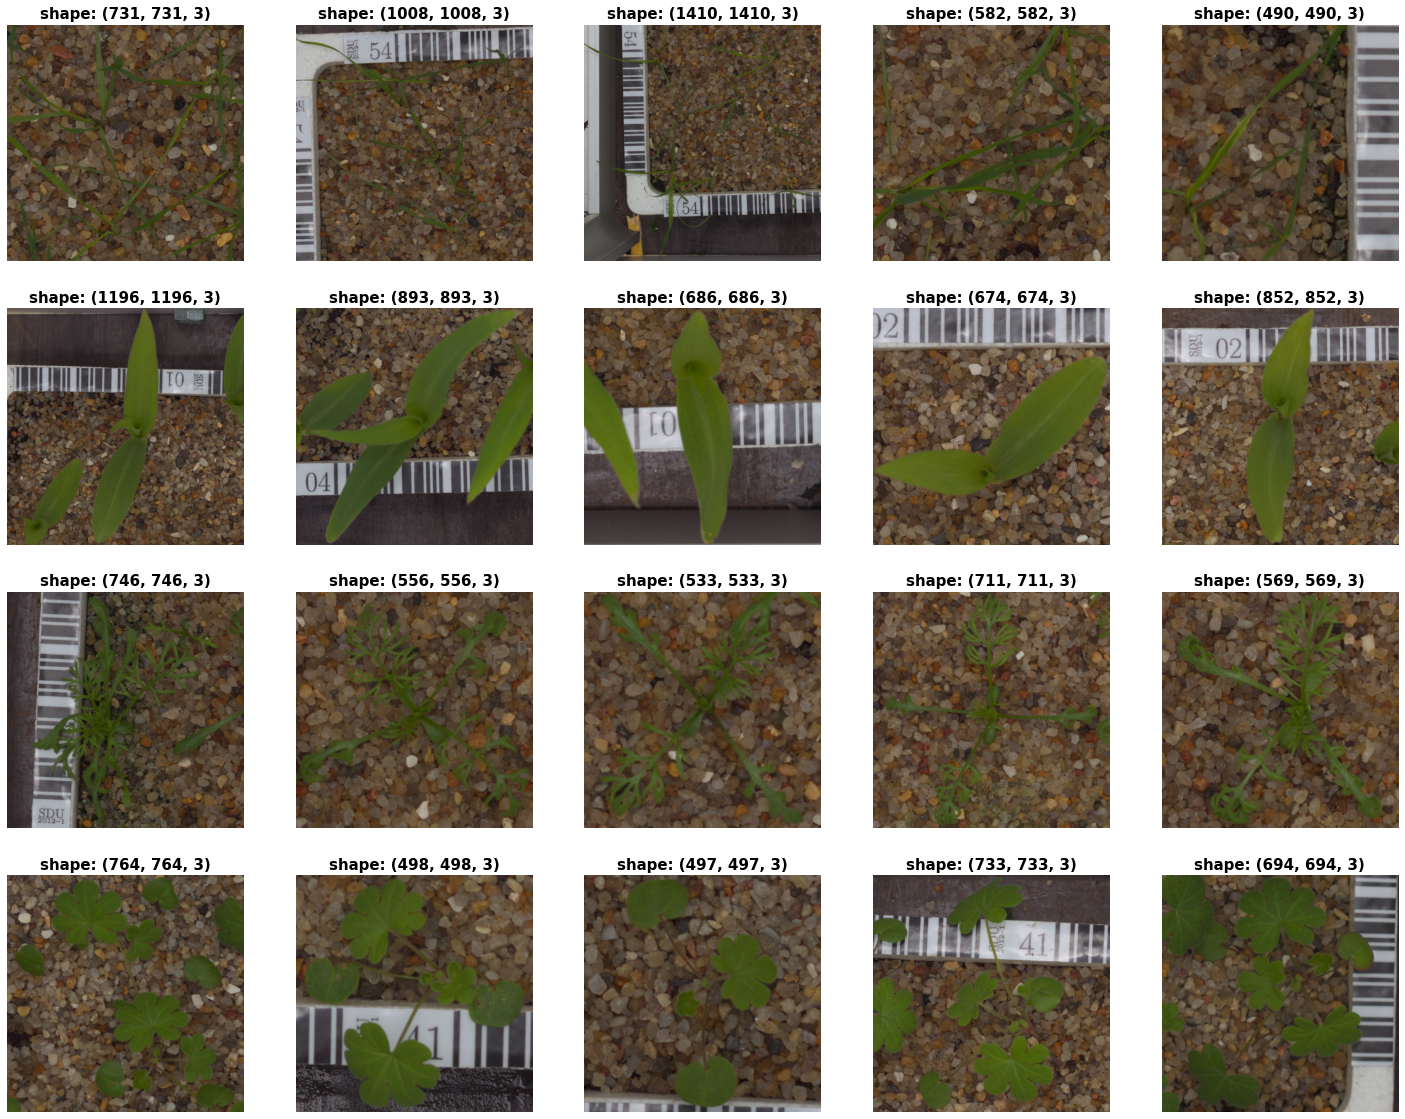

In [5]:
visualize_images(images, 4, 5)

**Вывод**: все картинки цветные, но их размеры не одинаковые. 

### 1.2. Выделение растений. 

Все картинки имеют достаточно детализированный фон, а также сторонние объекты, на которых мы бы не хотели сосредотачиваться. И уж тем более не хотелось бы, чтобы наш классификатор использовал информацию, не связанную с растениями, для принятия решений. С этой целью оставим на картинках только изображения растений с помощью функции `cv2.inRange()`.  

In [6]:
images_masked = []

for image in images:
    
    image_hsv = cv.cvtColor(image, code=cv.COLOR_RGB2HSV)
    image_mask = cv.inRange(image_hsv, green_low, green_high)
    image_masked = image * (image_mask[..., np.newaxis] // 255)
    image_gray = cv.cvtColor(image_masked, code=cv.COLOR_RGB2GRAY)
    images_masked.append(image_gray)

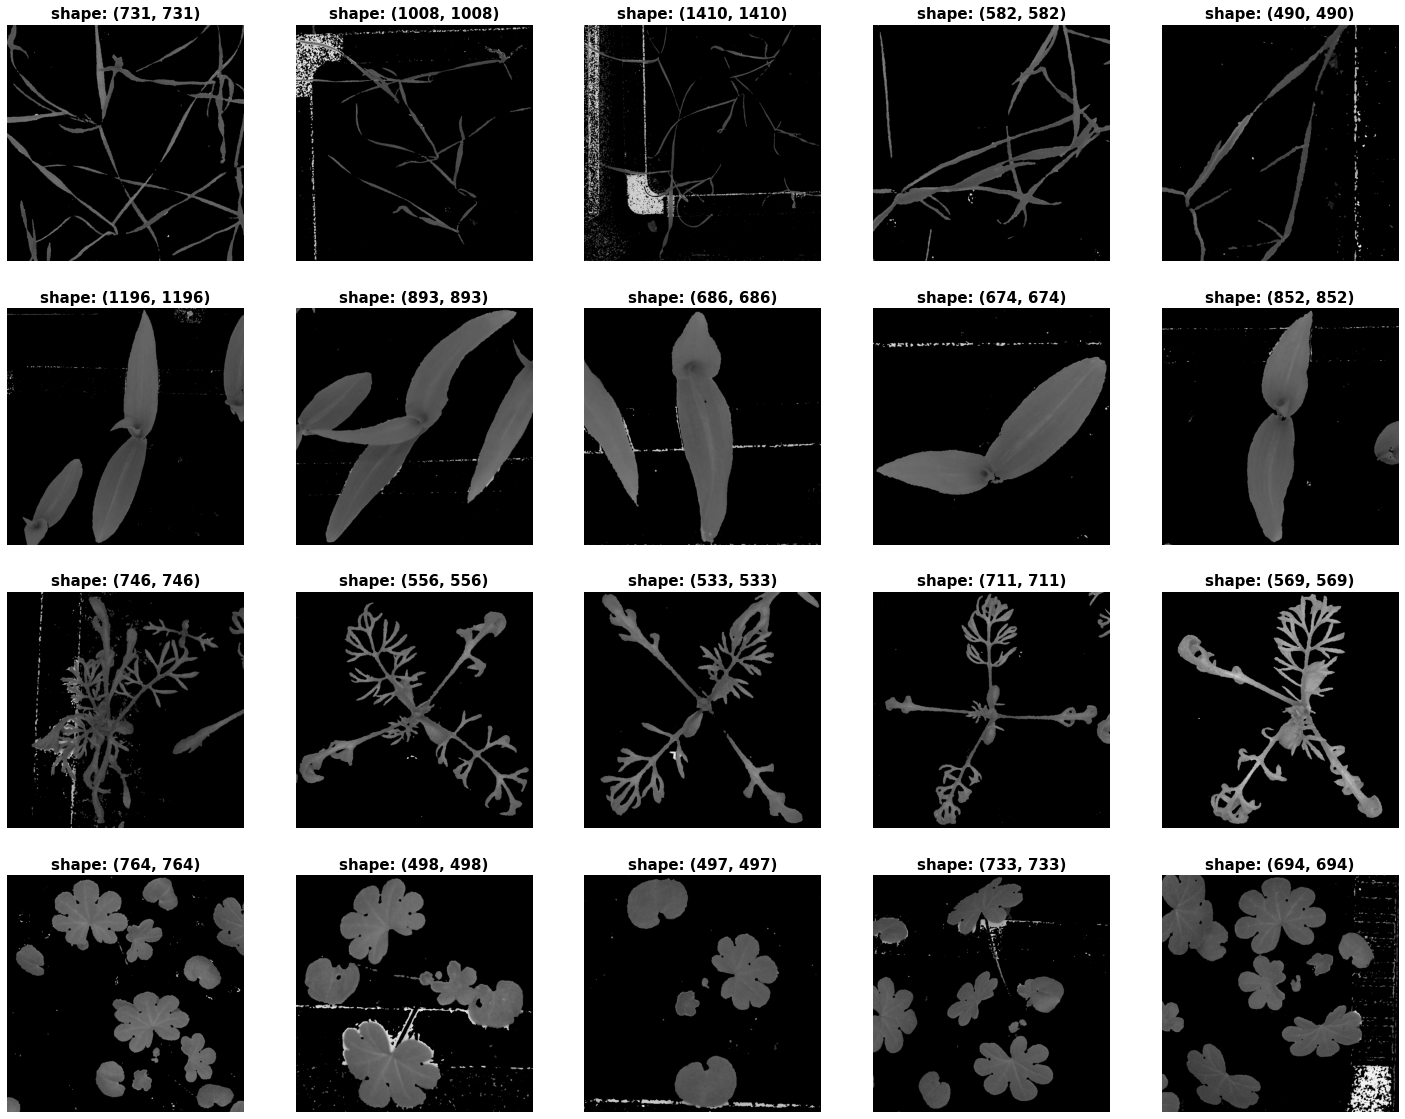

In [7]:
visualize_images(images_masked, 4, 5, cmap='gray')

### 1.3. Расширение выборки.

Для классификации мы будем обучать алгоритм машинного обучения, в связи с этим нам нужно больше обучающих данных. Увеличим число данных, путём применения афинных преобразований к имеющимся картинкам.

Мы будем применять поворот картинки. С этой целью воспользуемся кодом из первой домашки:

In [8]:
def rotate(image, point: tuple, angle: float) -> np.ndarray:
    """
    Повернуть изображение по часовой стрелке на угол от 0 до 360 градусов и преобразовать размер изображения.

    :param image: исходное изображение
    :param point: значение точки (x, y), вокруг которой повернуть изображение
    :param angle: угол поворота
    :return: повернутное изображение
    """
    verticies = np.array([[image.shape[1] - 1, image.shape[0] - 1],
                          [0, 0], [image.shape[1] - 1, 0],
                          [0, image.shape[0] - 1]])

    matrix = cv.getRotationMatrix2D(point, angle, scale=1.0)

    verticies_r3 = np.hstack((verticies, np.ones((verticies.shape[0], 1))))
    verticies_transformed = matrix @ verticies_r3.T

    matrix[:, 2] -= verticies_transformed.min(axis=1)
    new_shape = verticies_transformed.max(axis=1) - verticies_transformed.min(axis=1)
    new_shape = np.int64(np.ceil(new_shape))

    return cv.warpAffine(image, matrix, new_shape)

In [9]:
images, lbls = [], np.array([], dtype=np.uint8)

for i, image in enumerate(images_masked):
    
    for angle in range(0, 360, 15):
        
        rotated = rotate(image, (0, 0), angle)
        images.append(rotated)
        lbls = np.append(lbls, labels[i])
        
labels = lbls

### 1.4 Изменение размера.

Картинки имеют разный размер, что неприемлимо для обучения алгоритма машинного обучения. Необходимо изменить размер. С этой целью изменим размер каждой картинки с помощью функции `cv2.resize()`.

In [10]:
for i, image in enumerate(images):
    images[i] = cv.resize(image, shape_new)

### 1.5. Применим HOG.

Было бы неверно обучать наш алгоритм на "сырых" картинках. Для этого необходимо извелечь из каждой картинки более информативные признаки. К таким признакам относится гистограмма ориентированных градиентов(HOG). С помощью соответствующего класса библиотеки OpenCV получим вектор гистограмм ориентированных градиентов для каждой картинки, а затем полученные данные будем использовать для решения задачи классификации. 

In [11]:
hog = cv.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

for i, image in enumerate(images):
    images[i] = hog.compute(image)
    
images = np.array(images)

## 2. Выбор алгоритма.

In [12]:
models = {'rfc': RandomForestClassifier(),
          'svc': SVC()}

parametrs = {'svc': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                     'C': np.arange(0.1, 1.1, 0.1),
                     'class_weight': [None, 'balanced']},
             'rfc': {'n_estimators': np.arange(100, 501, 100),
                     'max_depth': [(i + 1) * 50 for i in range(5)] + [None],
                     'class_weight' : ['balanced', 'balanced_subsample', None]}}

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.8,
                                                    random_state=42)

In [14]:
model_best, accuracy_best = None, 0

for model_name, model in models.items():
    
    gscv = GridSearchCV(model, parametrs[model_name], scoring='accuracy',
                        n_jobs=-1)
    gscv.fit(x_train, y_train)
    
    if gscv.best_score_ > accuracy_best:
        accuracy_best = gscv.best_score_
        model_best = gscv.best_estimator_
    
    print(f'Model: {model_name};')
    print(f'Accuracy: {np.round(gscv.best_score_, 2)};\n')

Model: rfc;
Accuracy: 0.98;

Model: svc;
Accuracy: 0.97;



In [15]:
prediction = model_best.predict(x_test)
accuracy = accuracy_score(y_test, prediction)

print(f'Best model test score: {np.round(accuracy, 2)};')

Best model test score: 0.94;


## 3. Предсказание.

In [16]:
images_predict = []

for image_name in os.listdir(path_predict):
        
    image_path = f'{path_predict}{image_name}'
    
    image = cv.imread(image_path)
    image = cv.cvtColor(image, code=cv.COLOR_BGR2RGB)
        
    images_predict.append(image)

In [17]:
hog = cv.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)

for i, image in enumerate(images_predict):
    
    image_hsv = cv.cvtColor(image, code=cv.COLOR_RGB2HSV)
    image_mask = cv.inRange(image_hsv, green_low, green_high)
    image_masked = image * (image_mask[..., np.newaxis] // 255)
    image_gray = cv.cvtColor(image_masked, code=cv.COLOR_RGB2GRAY)
    images_predict[i] = hog.compute(cv.resize(image_gray, shape_new))

In [18]:
images_predict = np.array(images_predict)
labels_predict = np.array([0, 0, 1, 1, 0, 0, 2, 3, 1, 0,
                           1, 1, 0, 3, 2, 3, 2, 3, 0, 3,
                           2, 2, 3, 1, 3, 2, 2, 1, 3, 3,
                           0, 2, 0, 0, 1, 2, 3, 2, 1, 1],
                           dtype=np.uint8)

In [19]:
prediction = model_best.predict(images_predict)
accuracy = accuracy_score(labels_predict, prediction)

print(f'Accuracy: {accuracy};')

Accuracy: 0.775;
